## EXPLORE AND VISUALIZE Game Data for Michigan State and Future Opponents


In [41]:
# Depencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import sqlite3




# Connect to the SQLite database
db_path = '../../data/YTD_Game_Stats_Cleaned.db'  # Replace with your actual database path
conn = sqlite3.connect(db_path)

################### SET THE HIGHLIGHTED TEAMS ####################
# Highlight Michigan State and Boston College
highlight_teams_shots = ['MSU', 'BC']
highlight_colors_shots = {'MSU': 'darkgreen', 'BC': 'maroon'}
highlight_colors = {'MSU': 'darkgreen', 'BC': 'maroon'}

## List the tables in the database
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(tables)



                         name
0             scoring_summary
1             penalty_summary
2                goalie_stats
3                player_stats
4                  line_chart
5                   linescore
6      advanced_metrics_team1
7      advanced_metrics_team2
8            player_stats_ytd
9          master_roster_2023
10  advanced_metrics_combined
11               game_details


## Add Parameters for Font Styling

- Font Styling
- Default figure size

In [42]:
# Font parameters
font_param_dict = {'fontsize': 20, 'ha': 'center', 'va': 'bottom'}

# Default Aspect Ratio of all charts. Each block has section to comment in different aspect ratios
figure_default = (8, 6)
figure_size2 = (16, 12)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Load logos
msu_logo = plt.imread('../../images/logos/msu.png')
bc_logo = plt.imread('../../images/logos/bc_.png')

# Load Background Image
bg_img = plt.imread('../../images/backgrounds/bc1.png') # Square Image
bg_wide_img = plt.imread('../../images/backgrounds/wide1.png') # Wide Image
# Set Aplha Level of Background Image
aplha_val = 0.1

In [43]:


# Scale down the logos
# msu_logo = msu_logo[::3, ::3]
# bc_logo = bc_logo[::3, ::3]

# Function to plot logos
def plot_logo(image, x, y, ax, zoom=0.1):
    img = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(img, (x, y), frameon=False, xycoords='data', boxcoords="data", pad=0, box_alignment=(0.5, 0.5))
    ax.add_artist(ab)  # Don't forget this line

# Add logos
# Function to add logos to any plot
def add_logos_to_plot(df, x_col, y_col):
    for team, color in highlight_colors.items():
        team_data = df[df['Team'] == team]
        x, y = team_data[x_col].values[0], team_data[y_col].values[0]
        
        if team == "MSU":
            plot_logo(msu_logo, x, y, plt.gca())
        elif team == "BC":
            plot_logo(bc_logo, x, y, plt.gca())
        else:
            plt.scatter(x, y, color=color, s=100, zorder=5, marker='x')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


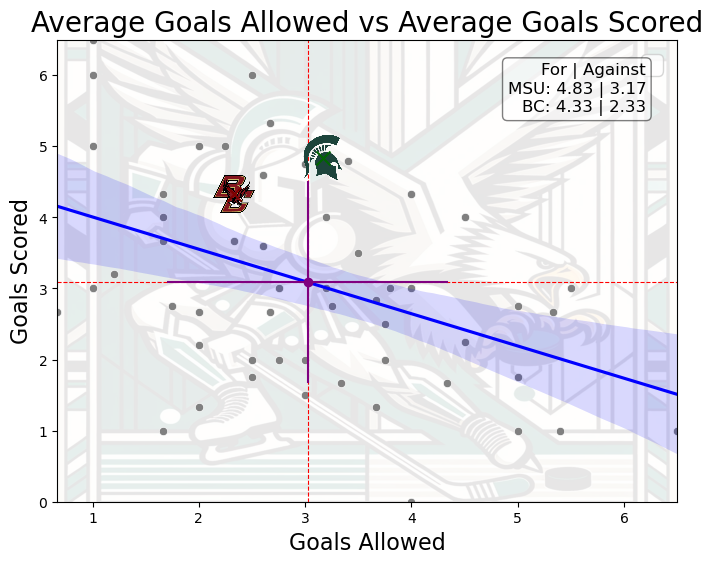

In [44]:

# Query to get the average goals scored and allowed per game for each team
avg_goals_query = """
SELECT
    a.Team,
    AVG(a.goalsT) AS Avg_Goals_Scored,
    AVG(b.goalsT) AS Avg_Goals_Allowed
FROM linescore AS a
JOIN linescore AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
GROUP BY a.Team;
"""

# Execute the query and store the results in a DataFrame
avg_goals_df = pd.read_sql(avg_goals_query, conn)

# Calculate average and standard deviation for "Goals Scored" and "Goals Allowed"
avg_goals_scored = avg_goals_df['Avg_Goals_Scored'].mean()
std_goals_scored = avg_goals_df['Avg_Goals_Scored'].std()
avg_goals_allowed = avg_goals_df['Avg_Goals_Allowed'].mean()
std_goals_allowed = avg_goals_df['Avg_Goals_Allowed'].std()


# Create the scatter plot with trend line, average, and standard deviation
plt.figure(figsize=figure_default)
# plt.figure(figsize=(12, 8)) # Inset custom aspect ratio HERE


# Set the background image
# You might need to adjust the extent based on your data's min and max values
plt.imshow(bg_img, aspect='auto', extent=[avg_goals_df['Avg_Goals_Allowed'].min(), 
                                          avg_goals_df['Avg_Goals_Allowed'].max(), 
                                          avg_goals_df['Avg_Goals_Scored'].min(), 
                                          avg_goals_df['Avg_Goals_Scored'].max()], 
                                          zorder=0, 
                                          alpha=aplha_val)



# Scatter plot
sns.scatterplot(data=avg_goals_df, x='Avg_Goals_Allowed', y='Avg_Goals_Scored', color='grey')

# Add trend line
sns.regplot(data=avg_goals_df, x='Avg_Goals_Allowed', y='Avg_Goals_Scored', scatter=False, color='blue')

# Add average lines
plt.axhline(y=avg_goals_scored, color='red', linestyle='--', linewidth=0.8)
plt.axvline(x=avg_goals_allowed, color='red', linestyle='--', linewidth=0.8)

# Add standard deviation lines
plt.errorbar(avg_goals_allowed, avg_goals_scored, xerr=std_goals_allowed, yerr=std_goals_scored, color='purple', fmt='o')

# Highlight specific teams
for team, color in highlight_colors.items():
    team_data = avg_goals_df[avg_goals_df['Team'] == team]
    plt.scatter(team_data['Avg_Goals_Allowed'], team_data['Avg_Goals_Scored'], color=color, s=100, zorder=5, marker='x')

# Add logos (assuming the function supports the swap)
add_logos_to_plot(avg_goals_df, 'Avg_Goals_Allowed', 'Avg_Goals_Scored')

############################
# Add a legend-like floating box in the upper right
# Create a multi-line summary text
summary_text = 'For | Against\n'
for team, color in highlight_colors.items():
    team_data = avg_goals_df[avg_goals_df['Team'] == team]
    summary_text += f'{team}: {team_data["Avg_Goals_Scored"].values[0]:.2f} | {team_data["Avg_Goals_Allowed"].values[0]:.2f}\n'

# Add the cohesive summary box
plt.gcf().text(0.95, 0.95, summary_text.rstrip(), transform=plt.gca().transAxes, fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black'))


# Add title and axis labels
plt.title('Average Goals Allowed vs Average Goals Scored', fontsize=20)
plt.xlabel('Goals Allowed', fontsize=16)
plt.ylabel('Goals Scored', fontsize=16)

# Upsize the Legend Text
plt.legend(fontsize=20)

plt.show()


## Average Shots Per Game (for and Against)



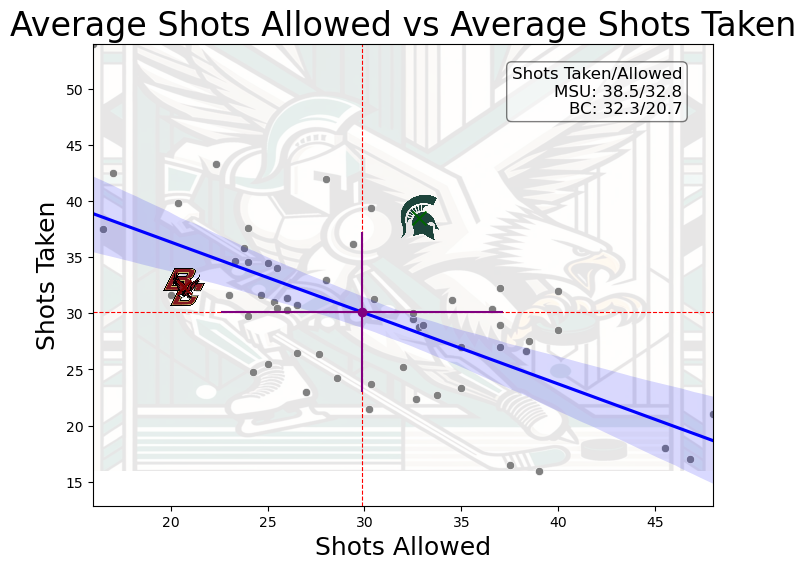

In [45]:
# Query to get the average shots taken and allowed per game for each team using the previous database connection
avg_shots_query = """
SELECT
    a.Team,
    AVG(a.shotsT) AS Avg_Shots_Taken,
    AVG(b.shotsT) AS Avg_Shots_Allowed
FROM linescore AS a
JOIN linescore AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
GROUP BY a.Team;
"""

# Execute the query and store the results in a DataFrame
avg_shots_df = pd.read_sql(avg_shots_query, conn)

# Calculate average and standard deviation for "Shots Taken" and "Shots Allowed"
avg_shots_taken = avg_shots_df['Avg_Shots_Taken'].mean()
std_shots_taken = avg_shots_df['Avg_Shots_Taken'].std()
avg_shots_allowed = avg_shots_df['Avg_Shots_Allowed'].mean()
std_shots_allowed = avg_shots_df['Avg_Shots_Allowed'].std()



# Create the scatter plot for average shots taken and allowed
plt.figure(figsize=figure_default)
# plt.figure(figsize=(12, 8)) # Inset custom aspect ratio HERE

# Set the background image
# You might need to adjust the extent based on your data's min and max values
plt.imshow(bg_img, aspect='auto', extent=[avg_shots_df['Avg_Shots_Allowed'].min(), 
                                          avg_shots_df['Avg_Shots_Allowed'].max(), 
                                          avg_shots_df['Avg_Shots_Taken'].min(), 
                                          avg_shots_df['Avg_Shots_Taken'].max()], 
                                          zorder=0, 
                                          alpha=aplha_val)


# Scatter plot
sns.scatterplot(data=avg_shots_df, x='Avg_Shots_Allowed', y='Avg_Shots_Taken', color='grey')

# Add trend line
sns.regplot(data=avg_shots_df, x='Avg_Shots_Allowed', y='Avg_Shots_Taken', scatter=False, color='blue')

# Add average lines
plt.axhline(y=avg_shots_taken, color='red', linestyle='--', linewidth=0.8)
plt.axvline(x=avg_shots_allowed, color='red', linestyle='--', linewidth=0.8)

# Add standard deviation lines
plt.errorbar(avg_shots_allowed, avg_shots_taken, xerr=std_shots_allowed, yerr=std_shots_taken, color='purple', fmt='o')

# Highlight specific teams
for team, color in highlight_colors_shots.items():
    team_data = avg_shots_df[avg_shots_df['Team'] == team]
    plt.scatter(team_data['Avg_Shots_Allowed'], team_data['Avg_Shots_Taken'], color=color, s=100, zorder=5, marker='x')

# Create a multi-line summary text
summary_text = 'Shots Taken/Allowed\n'
for team, color in highlight_colors_shots.items():
    team_data = avg_shots_df[avg_shots_df['Team'] == team]
    summary_text += f'{team}: {team_data["Avg_Shots_Taken"].values[0]:.1f}/{team_data["Avg_Shots_Allowed"].values[0]:.1f}\n'

# Add the cohesive summary box
plt.gcf().text(0.95, 0.95, summary_text.rstrip(), transform=plt.gca().transAxes, fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black'))

# Add title and axis labels
plt.title('Average Shots Allowed vs Average Shots Taken', fontsize=24)
plt.xlabel('Shots Allowed', fontsize=18)
plt.ylabel('Shots Taken', fontsize=18)

# Add logos (assuming the function supports the swap)
add_logos_to_plot(avg_shots_df, 'Avg_Shots_Allowed', 'Avg_Shots_Taken')

plt.show()



## Average penelty minutes per game

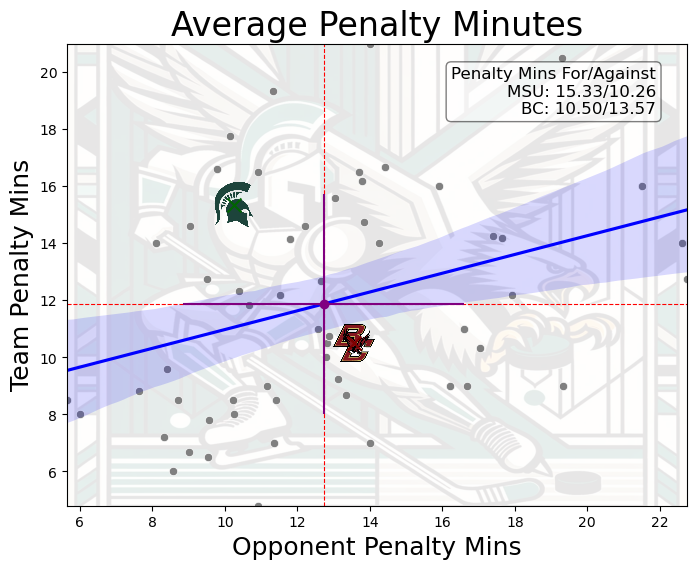

In [46]:
# SQL query to calculate the average penalty minutes "for" and "against" each team
avg_penalty_for_against_query = """
WITH PenaltyFor AS (
    SELECT
        Team,
        AVG(Total_Penalty_Minutes) AS Avg_Penalty_Minutes_For
    FROM (
        SELECT
            Team,
            Game_ID,
            SUM(Pen_Length) AS Total_Penalty_Minutes
        FROM penalty_summary
        GROUP BY Team, Game_ID
    )
    GROUP BY Team
),
PenaltyAgainst AS (
    SELECT
        b.Team,
        AVG(a.Total_Penalty_Minutes) AS Avg_Penalty_Minutes_Against
    FROM (
        SELECT
            Team,
            Game_ID,
            SUM(Pen_Length) AS Total_Penalty_Minutes
        FROM penalty_summary
        GROUP BY Team, Game_ID
    ) AS a
    JOIN penalty_summary AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
    GROUP BY b.Team
)
SELECT
    a.Team,
    a.Avg_Penalty_Minutes_For,
    b.Avg_Penalty_Minutes_Against
FROM PenaltyFor AS a
JOIN PenaltyAgainst AS b ON a.Team = b.Team;
"""

# Execute the query and store the results in a DataFrame
avg_penalty_for_against_df = pd.read_sql(avg_penalty_for_against_query, conn)
# avg_penalty_for_against_df.head()

# Calculate average and standard deviation for "For" and "Against"
avg_for = avg_penalty_for_against_df['Avg_Penalty_Minutes_For'].mean()
std_for = avg_penalty_for_against_df['Avg_Penalty_Minutes_For'].std()
avg_against = avg_penalty_for_against_df['Avg_Penalty_Minutes_Against'].mean()
std_against = avg_penalty_for_against_df['Avg_Penalty_Minutes_Against'].std()

#####################################################
## Figure Size
plt.figure(figsize=figure_default)
# plt.figure(figsize=(12, 8)) # Inset custom aspect ratio HERE

# Scatter plot
sns.scatterplot(data=avg_penalty_for_against_df, x='Avg_Penalty_Minutes_Against', y='Avg_Penalty_Minutes_For', color='grey')

# Add Background Image
plt.imshow(bg_img, aspect='auto', extent=[avg_penalty_for_against_df['Avg_Penalty_Minutes_Against'].min(), 
                                          avg_penalty_for_against_df['Avg_Penalty_Minutes_Against'].max(), 
                                          avg_penalty_for_against_df['Avg_Penalty_Minutes_For'].min(), 
                                          avg_penalty_for_against_df['Avg_Penalty_Minutes_For'].max()], 
                                          zorder=0, 
                                          alpha=aplha_val)

# Add trend line
sns.regplot(data=avg_penalty_for_against_df, x='Avg_Penalty_Minutes_Against', y='Avg_Penalty_Minutes_For', scatter=False, color='blue')

# Add average lines
plt.axhline(y=avg_for, color='red', linestyle='--', linewidth=0.8)
plt.axvline(x=avg_against, color='red', linestyle='--', linewidth=0.8)

# Add standard deviation lines
plt.errorbar(avg_against, avg_for, xerr=std_against, yerr=std_for, color='purple', fmt='o')

# Highlight specific teams
for team, color in highlight_colors_shots.items():
    team_data = avg_penalty_for_against_df[avg_penalty_for_against_df['Team'] == team]
    plt.scatter(team_data['Avg_Penalty_Minutes_Against'], team_data['Avg_Penalty_Minutes_For'], color=color, s=100, zorder=5, marker='x')

# Create a multi-line summary text
summary_text = 'Penalty Mins For/Against\n'
for team, color in highlight_colors_shots.items():
    team_data = avg_penalty_for_against_df[avg_penalty_for_against_df['Team'] == team]
    summary_text += f'{team}: {team_data["Avg_Penalty_Minutes_For"].values[0]:.2f}/{team_data["Avg_Penalty_Minutes_Against"].values[0]:.2f}\n'

# Add the cohesive summary box
plt.gcf().text(0.95, 0.95, summary_text.rstrip(), transform=plt.gca().transAxes, fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black'))

# Add title and axis labels
plt.title('Average Penalty Minutes', fontsize=24)
plt.xlabel('Opponent Penalty Mins', fontsize=18)
plt.ylabel('Team Penalty Mins', fontsize=18)

# Add logos (assuming the function supports the swap)
add_logos_to_plot(avg_penalty_for_against_df, 'Avg_Penalty_Minutes_Against', 'Avg_Penalty_Minutes_For')

plt.show()





# Goals Scored by Time of Game

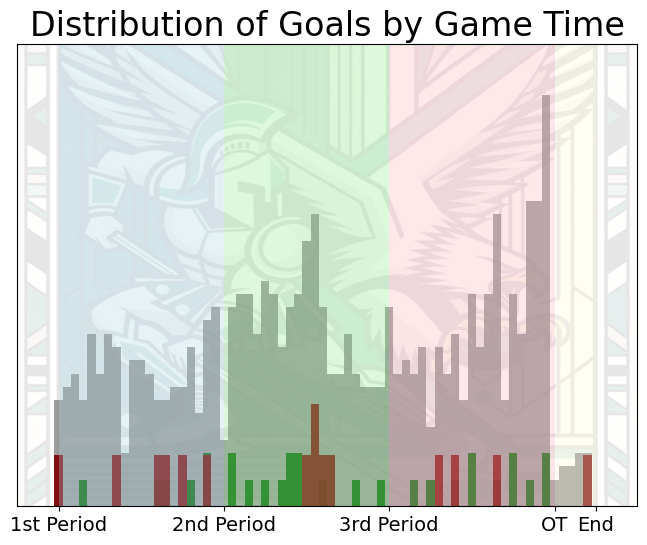

In [47]:
import matplotlib.ticker as ticker

# Query to get the time and period of goals scored by each team
goals_time_query = """
SELECT Team, Period, Time
FROM scoring_summary;
"""

# Execute the query and store the results in a DataFrame
goals_time_df = pd.read_sql(goals_time_query, conn)

# Convert Period and Time to a single continuous time in minutes
def convert_to_continuous_time(row):
    period = row['Period']
    time = row['Time']
    
    # Convert the period time to minutes and seconds
    minutes, seconds = map(int, time.split(':'))
    
    # Add the period offset to the time
    if period == '1st Period':
        offset = 0
    elif period == '2nd Period':
        offset = 20
    elif period == '3rd Period':
        offset = 40
    else:  # Overtime periods
        offset = 60
        
    return offset + minutes + seconds / 60.0

goals_time_df['Continuous_Time'] = goals_time_df.apply(convert_to_continuous_time, axis=1)



# goals_time_df.head()

###############################################################
# Create the histogram with improved visibility and period zones
plt.figure(figsize=figure_default)
# plt.figure(figsize=(12, 8)) # Inset custom aspect ratio HERE

# Add Background Image
plt.imshow(bg_img, aspect='auto', extent=[-5, 70, 0, .6], zorder=0, alpha=aplha_val)


# Plot the average goals by all teams in each 1-minute bin
all_teams_data = goals_time_df['Continuous_Time']
bin_counts, bin_edges = np.histogram(all_teams_data, bins=range(0, 66))
bin_avgs = bin_counts / len(np.unique(goals_time_df['Team']))
plt.bar(bin_edges[:-1], bin_avgs, width=1, alpha=0.5, label='All Teams (Avg)', color='grey')


# Plot the average goals by all teams in each 1-minute bin
bin_avgs_all_teams = bin_counts / len(np.unique(goals_time_df['Team']))
plt.bar(bin_edges[:-1], bin_avgs_all_teams, width=1, alpha=0.5, label='All Teams (Avg)', color='grey')

# Plot average goals by MSU and BC in 1-minute bins
for team, color in highlight_colors_shots.items():
    team_data = goals_time_df[goals_time_df['Team'] == team]['Continuous_Time']
    team_bin_counts, _ = np.histogram(team_data, bins=range(0, 66))
    team_bin_avgs = team_bin_counts / len(team_data)  # Normalize by the number of goals by the team
    plt.bar(bin_edges[:-1], team_bin_avgs, width=1, alpha=0.9, label=f"{team} (Avg)", color=color)


# Add period zones
plt.axvspan(0, 20, facecolor='lightblue', alpha=0.3, label='1st Period')
plt.axvspan(20, 40, facecolor='lightgreen', alpha=0.3, label='2nd Period')
plt.axvspan(40, 60, facecolor='lightpink', alpha=0.3, label='3rd Period')
plt.axvspan(60, 65, facecolor='lightyellow', alpha=0.3, label='Overtime')

# plt.title('Distribution of Goals Scored by Time (1-minute bins, Averaged)')
# Increase font size of title
plt.title('Distribution of Goals by Game Time', fontsize=24)
# plt.xlabel('Time (minutes)')
# plt.ylabel('Average Number of Goals')
# plt.legend()

# Customize x-axis with period zones
plt.xticks([0, 20, 40, 60, 65], ['1st Period', '2nd Period', '3rd Period', 'OT', 'End'])
# Increase font size of x-axis tick labels
plt.xticks(fontsize=14)

# Remove the tick marks from the y-axis for a cleaner look
plt.gca().yaxis.set_major_locator(ticker.NullLocator())
# plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()


## Create Top Five Reports for MSU and Opponent (Goals, shots, assists, PIMs, blocked shots)

In [48]:
# Adjust query to get player stats for each team in the categories of interest
# Note: Ignoring the player's number as per user's request
adjusted_player_stats_query = """
SELECT
    Team,
    Player,
    SUM(G) AS Total_Goals,
    SUM(Sh) AS Total_Shots,
    SUM(A) AS Total_Assists,
    SUM(PIM) AS Total_Penalty_Minutes
FROM player_stats
GROUP BY Team, Player
ORDER BY Team, Total_Goals DESC, Total_Shots DESC, Total_Assists DESC, Total_Penalty_Minutes DESC;
"""

# Execute the query and store the results in a DataFrame
adjusted_player_stats_df = pd.read_sql(adjusted_player_stats_query, conn)

#############################################################################
# FILTER THE DATAFRAME FOR THE TEAMS OF INTEREST
#############################################################################
# Filter the DataFrame to include only the stats for MSU and BC
msu_stats = adjusted_player_stats_df[adjusted_player_stats_df['Team'] == 'Michigan State']
bc_stats = adjusted_player_stats_df[adjusted_player_stats_df['Team'] == 'Boston College']

# Display the top players for each team in each category
def display_top_players(team_stats, team_name, categories):
    print(f"Top Players for {team_name}")
    for category in categories:
        print(f"\nTop Players in {category}:")
        display(team_stats.nlargest(5, category)[['Player', category]])

# Categories to display
categories = ['Total_Goals', 'Total_Shots', 'Total_Assists', 'Total_Penalty_Minutes']

# # Display the tables for MSU and BC
# display_top_players(msu_stats, 'Michigan State (MSU)', categories)
# print("\n" + "="*50 + "\n")
# display_top_players(bc_stats, 'Boston College (BC)', categories)


### Blocked Shots Tables for MSU and BC

In [49]:
# Query to get player stats for blocked shots, accounting for the team information in Game_ID
blocked_shots_query = """
WITH Team_Info AS (
    SELECT
        CASE 
            WHEN Game_ID LIKE '%Michigan State-%' THEN 'Michigan State'
            WHEN Game_ID LIKE '%-Michigan State' THEN 'Michigan State'
            WHEN Game_ID LIKE '%Boston College-%' THEN 'Boston College'
            WHEN Game_ID LIKE '%-Boston College' THEN 'Boston College'
        END AS Team,
        Game_ID,
        Player,
        TOTAL_Block AS Total_Shots_Blocked,
        D_Blocks AS Total_Defensive_Blocks
    FROM (
        SELECT * FROM advanced_metrics_team1
        UNION ALL
        SELECT * FROM advanced_metrics_team2
    )
    WHERE Game_ID LIKE '%Michigan State%' OR Game_ID LIKE '%Boston College%'
)
SELECT
    Team,
    Player,
    SUM(Total_Shots_Blocked) AS Total_Shots_Blocked,
    SUM(Total_Defensive_Blocks) AS Total_Defensive_Blocks
FROM Team_Info
GROUP BY Team, Player
ORDER BY Team, Total_Shots_Blocked DESC, Total_Defensive_Blocks DESC;
"""

# Execute the query and store the results in a DataFrame
blocked_shots_df = pd.read_sql(blocked_shots_query, conn)

# Filter the DataFrame to include only the stats for Michigan State and Boston College
msu_blocked_shots_stats = blocked_shots_df[blocked_shots_df['Team'] == 'Michigan State']
bc_blocked_shots_stats = blocked_shots_df[blocked_shots_df['Team'] == 'Boston College']

# Categories for blocked shots
blocked_shots_categories = ['Total_Shots_Blocked', 'Total_Defensive_Blocks']

# # Display the tables for MSU and BC for blocked shots
# display_top_players(msu_blocked_shots_stats, 'Michigan State', blocked_shots_categories)
# print("\n" + "="*50 + "\n")
# display_top_players(bc_blocked_shots_stats, 'Boston College', blocked_shots_categories)


## Breakdown Player Goals, Assists and Penelty Minutes by Line Assignment

In [50]:
# Query to get line-specific stats for goals, assists, and penalty minutes scored for each team,
# now also including the Position column to distinguish between Forwards and Defensemen
line_goals_assists_pim_position_query = """
SELECT
    lc.Team,
    lc.Line,
    lc.Position,
    SUM(ps.G) AS Total_Goals,
    SUM(ps.A) AS Total_Assists,
    SUM(ps.PIM) AS Total_PIM,
    SUM(ps.G) + SUM(ps.A) AS Total_Points,
    SUM(ps.Sh) AS Total_Shots
FROM line_chart AS lc
LEFT JOIN player_stats AS ps ON lc.Game_ID = ps.Game_ID AND lc.Team = ps.Team AND lc.Player = ps.Player
WHERE lc.Position != 'Goalie'
GROUP BY lc.Team, lc.Line, lc.Position
ORDER BY lc.Team, lc.Line, lc.Position;
"""

# Execute the query and store the results in a DataFrame
line_goals_assists_pim_position_df = pd.read_sql(line_goals_assists_pim_position_query, conn)

# Create a new column 'Type' to distinguish between Forwards and Defensemen
line_goals_assists_pim_position_df['Type'] = line_goals_assists_pim_position_df['Position'].apply(lambda x: 'Forward' if x in ['Left Wing', 'Right Wing', 'Center'] else 'Defense')

# Preview the first few rows of the DataFrame to ensure the data looks as expected
# line_goals_assists_pim_position_df.head()


C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2037981581.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2037981581.py:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2037981581.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])],
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2037981581.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.bar

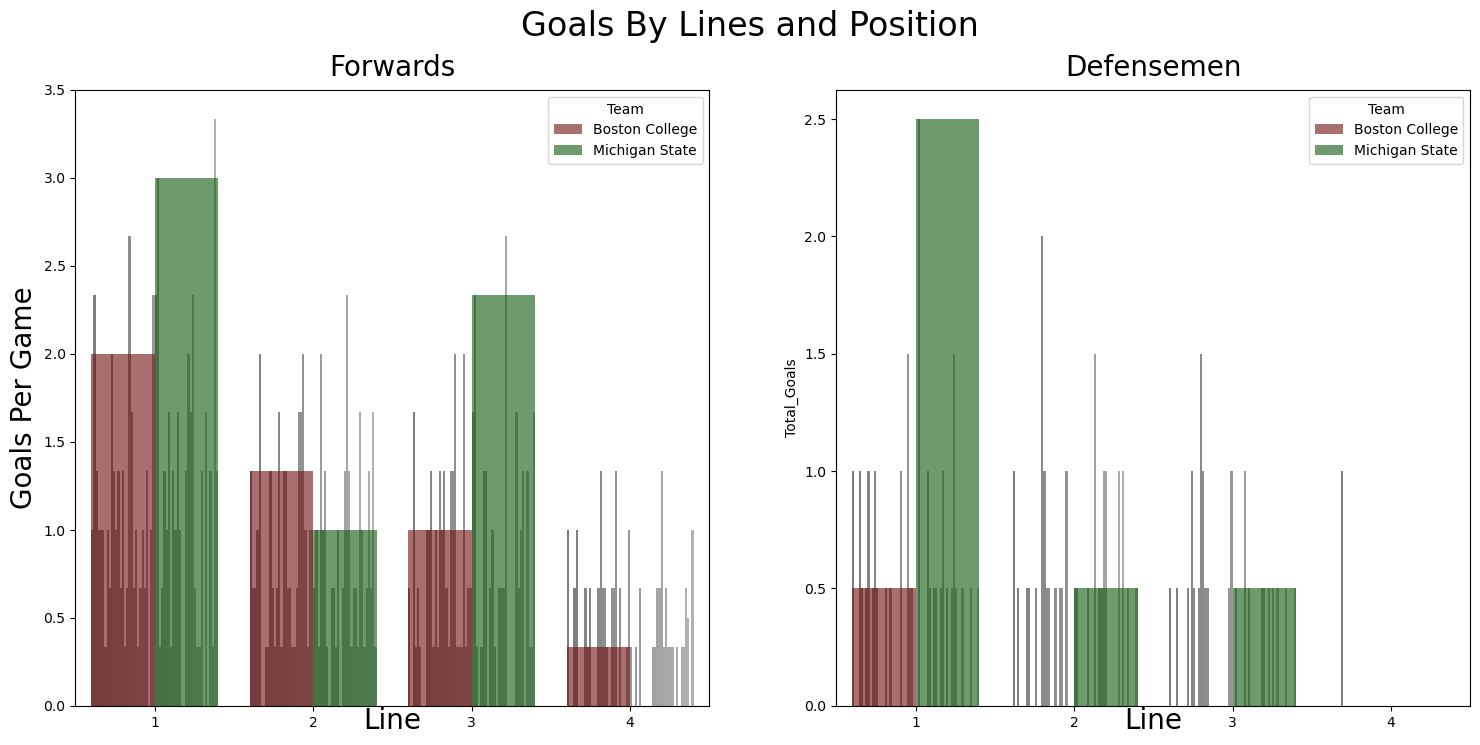

In [51]:
# Set up the plot
fig, ax = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle('Goals By Lines and Position', fontsize=24)

# Filter data for Forwards and Defensemen
forwards_data = line_goals_assists_pim_position_df[line_goals_assists_pim_position_df['Type'] == 'Forward']
defense_data = line_goals_assists_pim_position_df[line_goals_assists_pim_position_df['Type'] == 'Defense']

# Plot data for Forwards
sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data, 
            color='grey', alpha=0.6, ax=ax[0], ci=None)
sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[0], ci=None, alpha=0.6)

# Plot data for Defensemen
sns.barplot(x='Line', y='Total_Goals', hue='Team', data=defense_data, 
            color='grey', alpha=0.6, ax=ax[1], ci=None)
sns.barplot(x='Line', y='Total_Goals', hue='Team', data=defense_data[defense_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[1], ci=None, alpha=0.6)

# Add labels and title
ax[0].set_title('Forwards', font_param_dict)
ax[1].set_title('Defensemen', font_param_dict)
ax[0].set_xlabel('Line', font_param_dict)
ax[1].set_xlabel('Line', font_param_dict)
ax[0].set_ylabel('Goals Per Game', font_param_dict)
# ax[1].set_ylabel('Total Goals', font_param_dict)

# Simplify the legend to only show Michigan State and Boston College
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[-2:], labels[-2:], title='Team')

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[-2:], labels[-2:], title='Team')

# Show the plot
plt.show()


## Shots by Line and Position


C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2265113044.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Shots', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2265113044.py:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='Line', y='Total_Shots', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2265113044.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Shots', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])],
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2265113044.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.bar

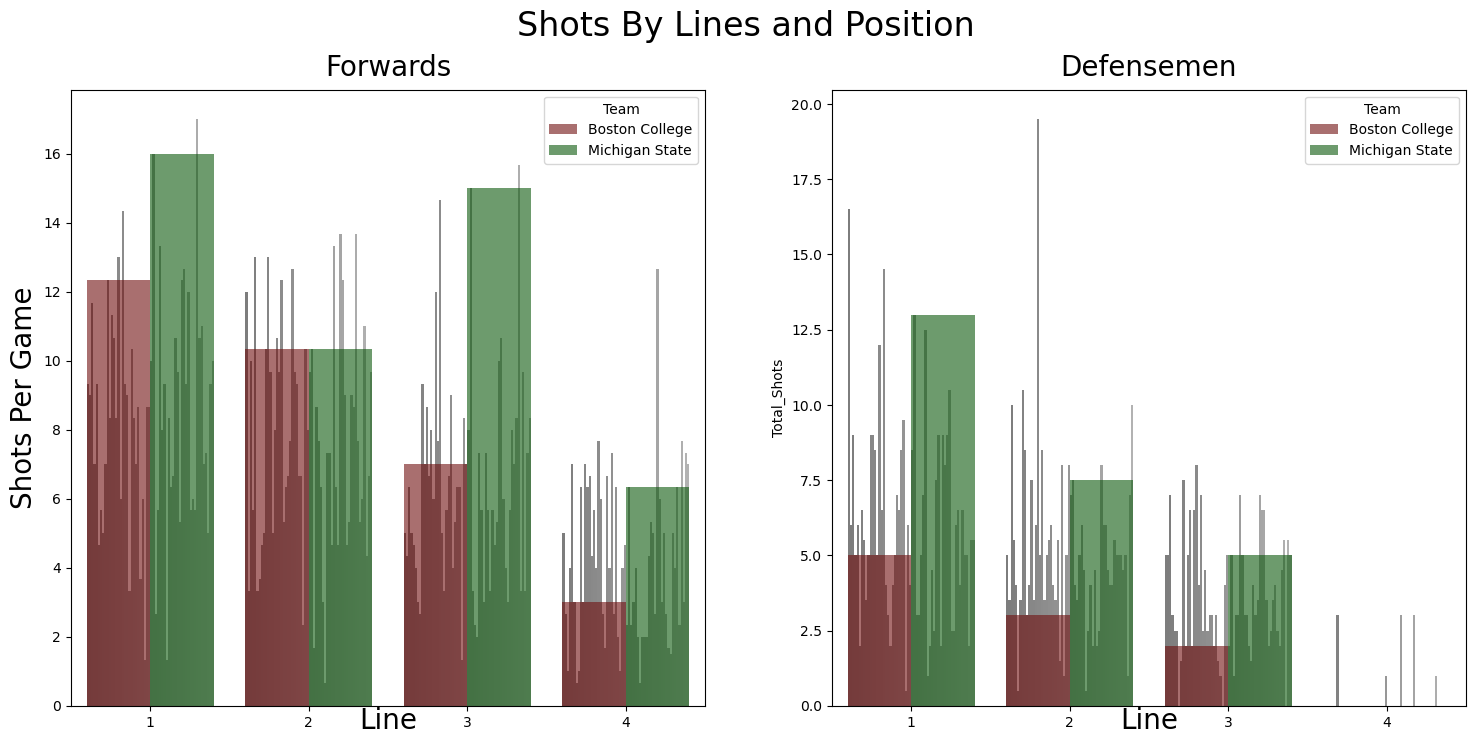

In [52]:
# Set up the plot
fig, ax = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle('Shots By Lines and Position', fontsize=24)

# Filter data for Forwards and Defensemen
forwards_data = line_goals_assists_pim_position_df[line_goals_assists_pim_position_df['Type'] == 'Forward']
defense_data = line_goals_assists_pim_position_df[line_goals_assists_pim_position_df['Type'] == 'Defense']

# Plot data for Forwards
sns.barplot(x='Line', y='Total_Shots', hue='Team', data=forwards_data, 
            color='grey', alpha=0.6, ax=ax[0], ci=None)
sns.barplot(x='Line', y='Total_Shots', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[0], ci=None, alpha=0.6)

# Plot data for Defensemen
sns.barplot(x='Line', y='Total_Shots', hue='Team', data=defense_data, 
            color='grey', alpha=0.6, ax=ax[1], ci=None)
sns.barplot(x='Line', y='Total_Shots', hue='Team', data=defense_data[defense_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[1], ci=None, alpha=0.6)

# Add labels and title
ax[0].set_title('Forwards', font_param_dict)
ax[1].set_title('Defensemen', font_param_dict)
ax[0].set_xlabel('Line', font_param_dict)
ax[1].set_xlabel('Line', font_param_dict)
ax[0].set_ylabel('Shots Per Game', font_param_dict)
# ax[1].set_ylabel('Total Goals', font_param_dict)

# Simplify the legend to only show Michigan State and Boston College
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[-2:], labels[-2:], title='Team')

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[-2:], labels[-2:], title='Team')

# Show the plot
plt.show()


## Assists by Line Assignment

C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\655450614.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\655450614.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\655450614.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])],
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\655450614.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barp

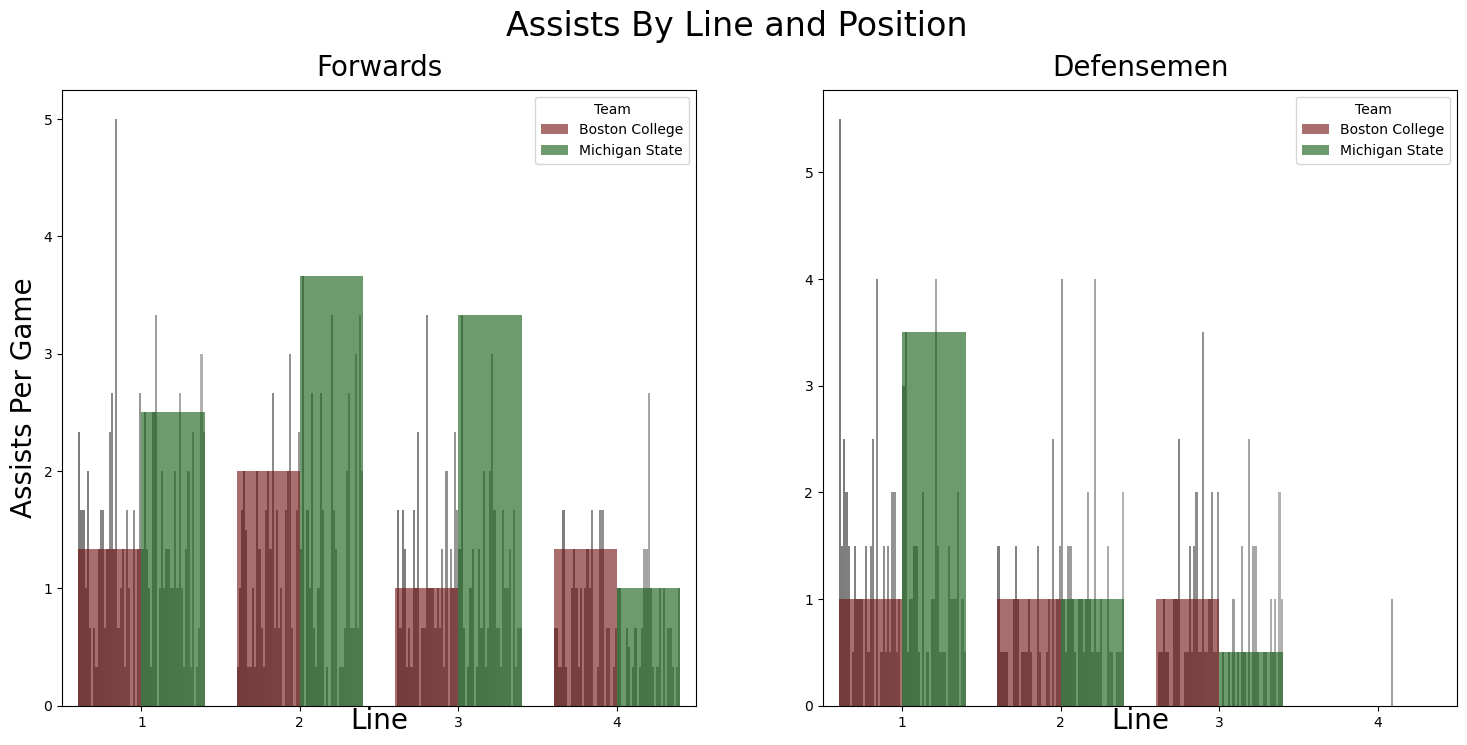

In [53]:
# Set up the plot for Assists
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Assists By Line and Position', fontsize=24)

# Plot data for Forwards
sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data, 
            color='grey', alpha=0.6, ax=ax[0], ci=None)
sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[0], ci=None, alpha=0.6)

# Plot data for Defensemen
sns.barplot(x='Line', y='Total_Assists', hue='Team', data=defense_data, 
            color='grey', alpha=0.6, ax=ax[1], ci=None)
sns.barplot(x='Line', y='Total_Assists', hue='Team', data=defense_data[defense_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[1], ci=None, alpha=0.6)

# Add labels and title
ax[0].set_title('Forwards', font_param_dict)
ax[1].set_title('Defensemen', font_param_dict)
ax[0].set_xlabel('Line', font_param_dict)
ax[1].set_xlabel('Line', font_param_dict)
ax[0].set_ylabel('Assists Per Game', font_param_dict)
ax[1].set_ylabel('', font_param_dict) # y lable on right plot is redundant

# Simplify the legend to only show Michigan State and Boston College
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[-2:], labels[-2:], title='Team')

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[-2:], labels[-2:], title='Team')

# Show the plot
plt.show()


## Penalty Minutes By Line Assignment

C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2072249682.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2072249682.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2072249682.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])],
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\2072249682.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='L

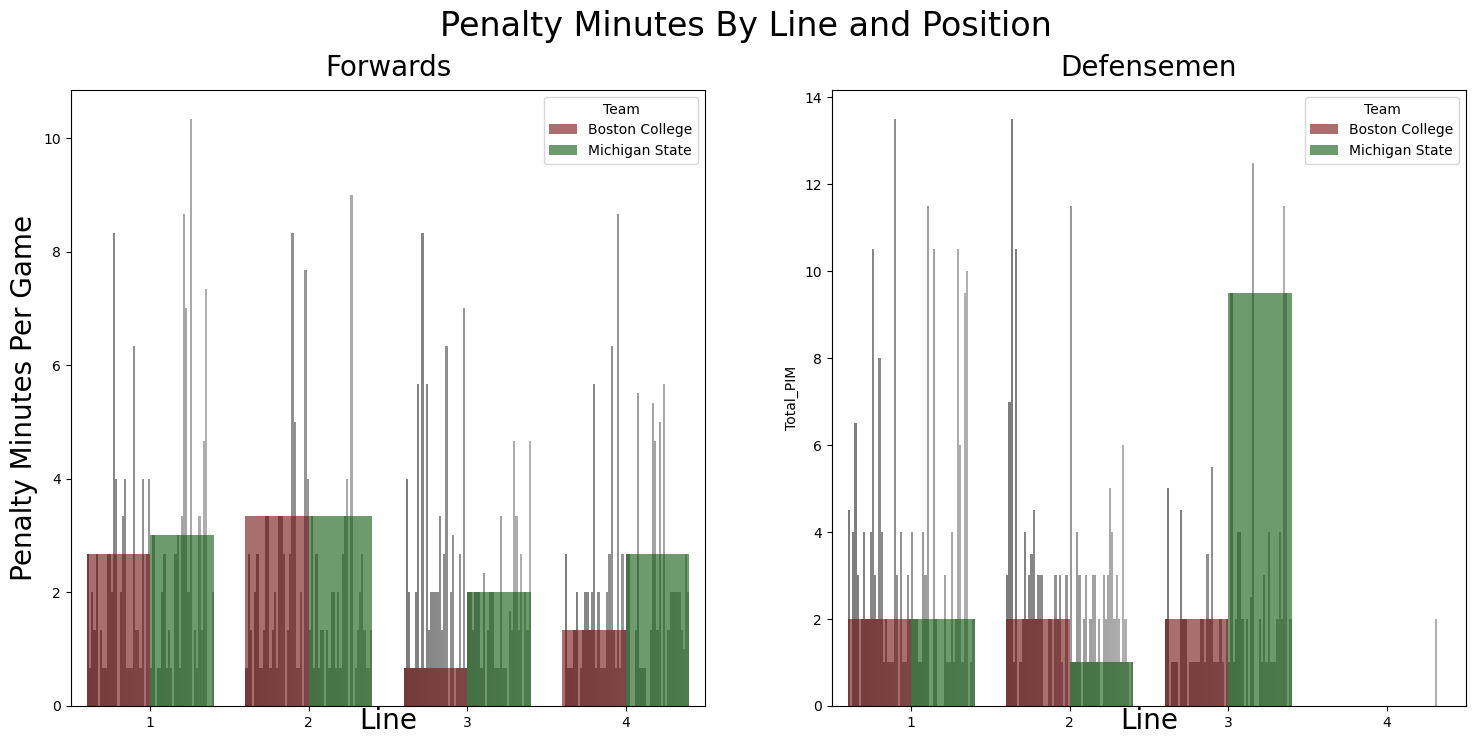

In [54]:
# Set up the plot for Penalty Minutes
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Penalty Minutes By Line and Position', fontsize=24)

# Plot data for Forwards
sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data, 
            color='grey', alpha=0.6, ax=ax[0], ci=None)
sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[0], ci=None, alpha=0.6)

# Plot data for Defensemen
sns.barplot(x='Line', y='Total_PIM', hue='Team', data=defense_data, 
            color='grey', alpha=0.6, ax=ax[1], ci=None)
sns.barplot(x='Line', y='Total_PIM', hue='Team', data=defense_data[defense_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[1], ci=None, alpha=0.6)


# Add labels and title
ax[0].set_title('Forwards', font_param_dict)
ax[1].set_title('Defensemen', font_param_dict)
ax[0].set_xlabel('Line', font_param_dict)
ax[1].set_xlabel('Line', font_param_dict)
ax[0].set_ylabel('Penalty Minutes Per Game', font_param_dict)
# ax[1].set_ylabel('Penalty Minutes Per Game', font_param_dict)

# Simplify the legend to only show Michigan State and Boston College
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[-2:], labels[-2:], title='Team')

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[-2:], labels[-2:], title='Team')

# Show the plot
plt.show()


In [55]:
## Check the database tables

# List the tables in the database
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(tables)

                         name
0             scoring_summary
1             penalty_summary
2                goalie_stats
3                player_stats
4                  line_chart
5                   linescore
6      advanced_metrics_team1
7      advanced_metrics_team2
8            player_stats_ytd
9          master_roster_2023
10  advanced_metrics_combined
11               game_details


## Plots for Stats by class Rank 

In [56]:
# SQL query to get goals by class rank ('Yr.') for all schools
# Replace spaces in school names with hyphens for the join operation
goals_by_class_all_schools_query = """
SELECT
    REPLACE(mr.School, '-', ' ') AS Team,
    mr."Yr." AS Class_Rank,
    SUM(ps.G) AS Total_Goals
FROM player_stats_ytd AS ps
LEFT JOIN master_roster_2023 AS mr ON ps.Clean_Player = mr.Clean_Name AND REPLACE(ps.Team, ' ', '-') = mr.School
GROUP BY ps.Team, mr."Yr."
ORDER BY ps.Team, mr."Yr.";
"""

# Execute the query and store the results in a DataFrame
goals_by_class_all_schools_df = pd.read_sql(goals_by_class_all_schools_query, conn)

# Preview the first few rows of the DataFrame to ensure the data looks as expected
goals_by_class_all_schools_df.head()



,Team,Class_Rank,Total_Goals
0,None,None,21
1,Alaska,Fr,0
2,Alaska,Gr,2
3,Alaska,Jr,15
4,Alaska,So,0


C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\1899196576.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y='Total_Goals', hue='Team', data=class_rank_stats_df,


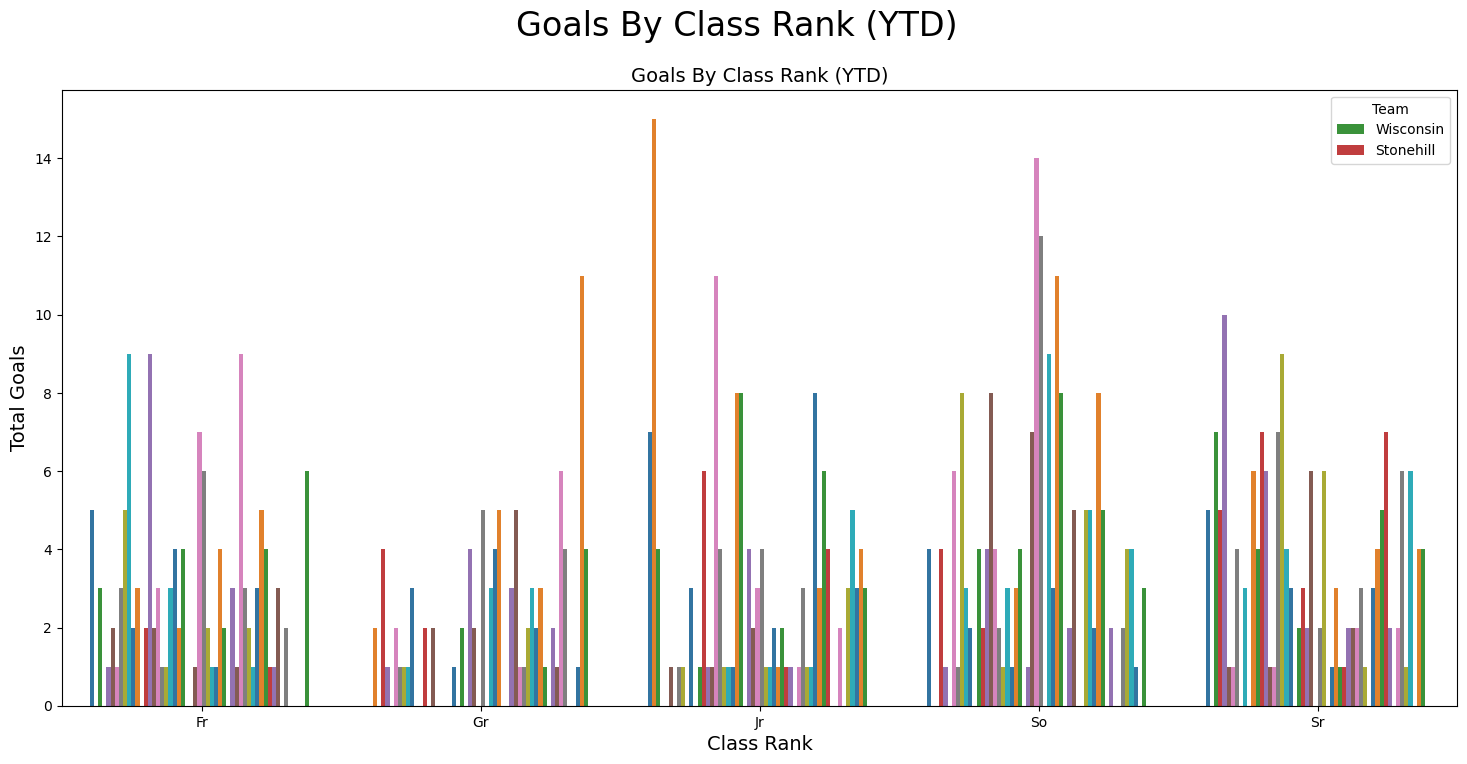

In [57]:
######################
# Preliminary table that plots all teams

# Update the query to use the correct table "player_stats_ytd" and correct column name "Clean_Player"
class_rank_stats_query_final_ytd = """
SELECT
    mr.`Yr.`,
    ps.Team,
    SUM(ps.G) AS Total_Goals,
    SUM(ps.A) AS Total_Assists,
    SUM(ps.PIM) AS Total_PIM,
    SUM(ps.Sh) AS Total_Shots
FROM master_roster_2023 AS mr
LEFT JOIN player_stats_ytd AS ps ON mr.Clean_Name = ps.Clean_Player
GROUP BY mr.`Yr.`, ps.Team
ORDER BY mr.`Yr.`, ps.Team;
"""

# Execute the final query and store the results in a DataFrame
class_rank_stats_df = pd.read_sql(class_rank_stats_query_final_ytd, conn)

# Set up the plot
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle('Goals By Class Rank (YTD)', fontsize=24)

# Plot the data
sns.barplot(x='Yr.', y='Total_Goals', hue='Team', data=class_rank_stats_df, 
            palette='tab10', ax=ax, ci=None)

# Add labels and title
font_param_dict = {'fontsize': 14}
ax.set_title('Goals By Class Rank (YTD)', font_param_dict)
ax.set_xlabel('Class Rank', font_param_dict)
ax.set_ylabel('Total Goals', font_param_dict)

# Simplify the legend to only show Michigan State and Boston College
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:], title='Team')



# Show the plot
# plt.show()


C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\4180350665.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y='Total_Goals', hue='Team', data=class_rank_stats_df,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\4180350665.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y='Total_Goals', hue='Team', data=msu_bc_data,


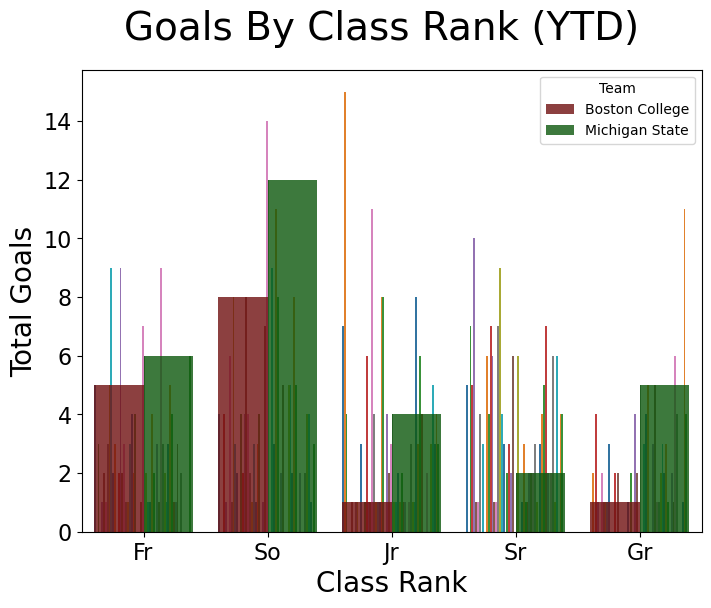

In [58]:
# Execute the provided query to get class rank stats for all teams
class_rank_stats_df = pd.read_sql("""
SELECT
    mr.`Yr.`,
    ps.Team,
    SUM(ps.G) AS Total_Goals,
    SUM(ps.A) AS Total_Assists,
    SUM(ps.PIM) AS Total_PIM,
    SUM(ps.Sh) AS Total_Shots
FROM master_roster_2023 AS mr
LEFT JOIN player_stats_ytd AS ps ON mr.Clean_Name = ps.Clean_Player
GROUP BY mr.`Yr.`, ps.Team
ORDER BY mr.`Yr.`, ps.Team;
""", conn)

# Filter data for Michigan State and Boston College
msu_bc_data = class_rank_stats_df[class_rank_stats_df['Team'].isin(['Michigan State', 'Boston College'])]

# Set up the plot
fig, ax = plt.subplots(figsize=(figure_default))
fig.suptitle('Goals By Class Rank (YTD)', fontsize=28)

# Class rank order
class_rank_order = ['Fr', 'So', 'Jr', 'Sr', 'Gr']

# Plot data for all teams using the 'tab10' palette
sns.barplot(x='Yr.', y='Total_Goals', hue='Team', data=class_rank_stats_df, 
            palette='tab10', ax=ax, ci=None, order=class_rank_order)

# Overlay larger, more opaque bars for Michigan State and Boston College
sns.barplot(x='Yr.', y='Total_Goals', hue='Team', data=msu_bc_data, 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax, ci=None, alpha=0.8)


# Enlarge the fonts
font_param_dict = {'fontsize': 20}
# Add labels and title
ax.set_xlabel('Class Rank', font_param_dict)
ax.set_ylabel('Total Goals', font_param_dict)

# Increase the font size of the tick marks
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)



# Simplify the legend to only show Michigan State and Boston College
handles, labels = ax.get_legend_handles_labels()
# Only keep the last two handles for Michigan State and Boston College
ax.legend(handles[-2:], labels[-2:], title='Team')

# Show the plot
plt.show()


## Other stats by class rank created in the same style

## FOUR WAY SUB PLOT OF Goals, Assists, Shots, PIM

In [59]:
# # Create subplots for 4 different metrics: Goals, Assists, Penalty Minutes, and Shots
# fig, axes = plt.subplots(2, 2, figsize=(24, 16))
# fig.suptitle('Team Stats By Class Rank (YTD)', fontsize=30)

# # Metrics to plot
# metrics = ['Total_Goals', 'Total_Assists', 'Total_PIM', 'Shots']
# titles = ['Goals', 'Assists', 'Penalty Minutes', 'Shots']

# # Loop through metrics and corresponding subplots
# for ax, metric, title in zip(axes.flatten(), metrics, titles):
#     # Query to get stats by class rank for the given metric
#     class_rank_stats_query = f"""
#     SELECT
#         mr.`Yr.`,
#         ps.Team,
#         SUM(ps.G) AS Total_Goals,
#         SUM(ps.A) AS Total_Assists,
#         SUM(ps.PIM) AS Total_PIM,
#         SUM(ps.Sh) AS Shots
#     FROM master_roster_2023 AS mr
#     LEFT JOIN player_stats_ytd AS ps ON mr.Clean_Name = ps.Clean_Player
#     GROUP BY mr.`Yr.`, ps.Team
#     ORDER BY mr.`Yr.`, ps.Team;
#     """
    
#     # Execute the query and store the results in a DataFrame
#     class_rank_stats_df = pd.read_sql(class_rank_stats_query, conn)
    
#     # Filter data for Michigan State and Boston College
#     msu_bc_data = class_rank_stats_df[class_rank_stats_df['Team'].isin(['Michigan State', 'Boston College'])]
    
#     # Plot data for all teams using the 'tab10' palette
#     sns.barplot(x='Yr.', y=metric, hue='Team', data=class_rank_stats_df, 
#                 palette='tab10', ax=ax, ci=None, order=class_rank_order)
    
#     # Overlay larger, more opaque bars for Michigan State and Boston College
#     sns.barplot(x='Yr.', y=metric, hue='Team', data=msu_bc_data, 
#                 palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax, ci=None, alpha=0.8, order=class_rank_order)
    
#     # Add labels and title
#     ax.set_title(title, fontsize=20)
#     ax.set_xlabel('Class Rank', fontsize=16)
#     ax.set_ylabel(title, fontsize=16)
    
#     # Simplify the legend to only show Michigan State and Boston College
#     handles, labels = ax.get_legend_handles_labels()
#     # Only keep the last two handles for Michigan State and Boston College
#     ax.legend(handles[-2:], labels[-2:], title='Team')

## # Show the plots
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()


In [60]:
msu_bc_data.head()

,Yr.,Team,Total_Goals,Total_Assists,Total_PIM,Total_Shots
9,Fr,Boston College,5.0,8.0,14.0,40.0
28,Fr,Michigan State,6.0,9.0,25.0,61.0
61,Gr,Boston College,1.0,1.0,4.0,3.0
77,Gr,Michigan State,5.0,9.0,6.0,33.0
110,Jr,Boston College,1.0,4.0,2.0,10.0


C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\422352189.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y=metric, hue='Team', data=class_rank_stats_df,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\422352189.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y=metric, hue='Team', data=msu_bc_data,


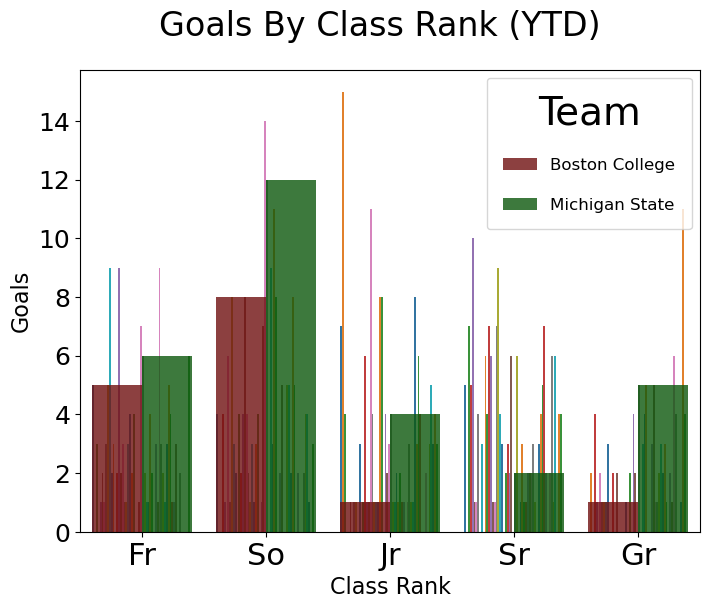

C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\422352189.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y=metric, hue='Team', data=class_rank_stats_df,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\422352189.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y=metric, hue='Team', data=msu_bc_data,


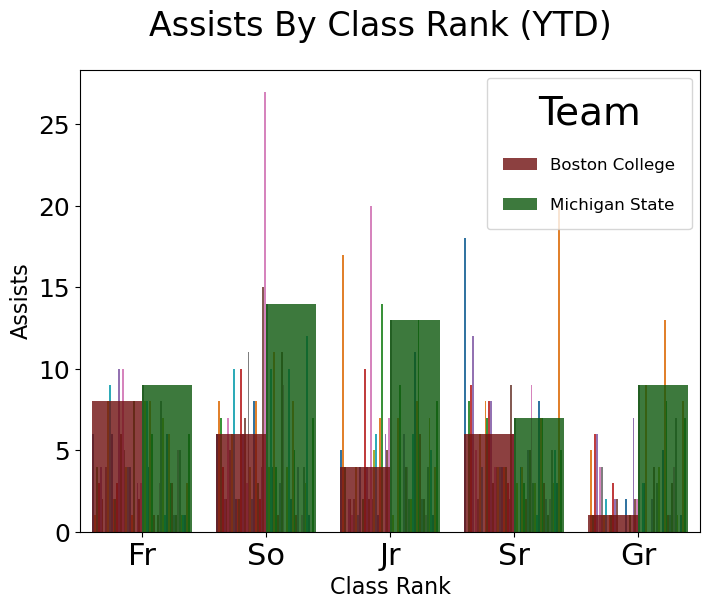

C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\422352189.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y=metric, hue='Team', data=class_rank_stats_df,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\422352189.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y=metric, hue='Team', data=msu_bc_data,


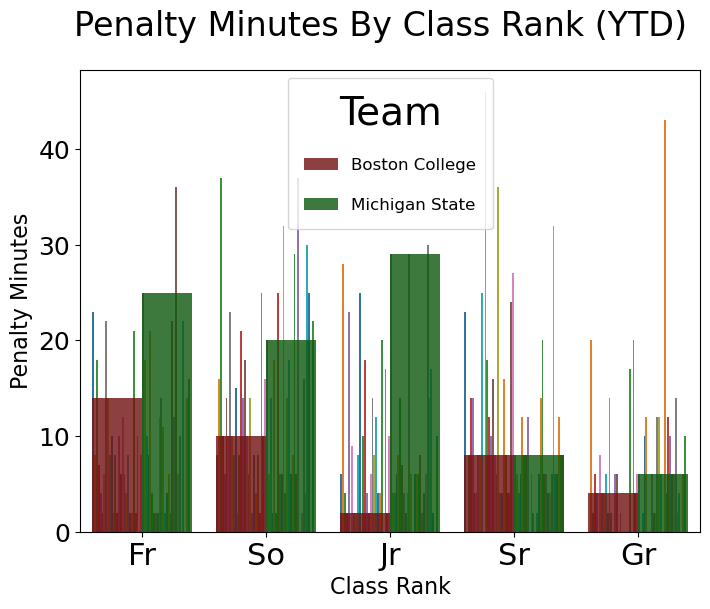

C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\422352189.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y=metric, hue='Team', data=class_rank_stats_df,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14652\422352189.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Yr.', y=metric, hue='Team', data=msu_bc_data,


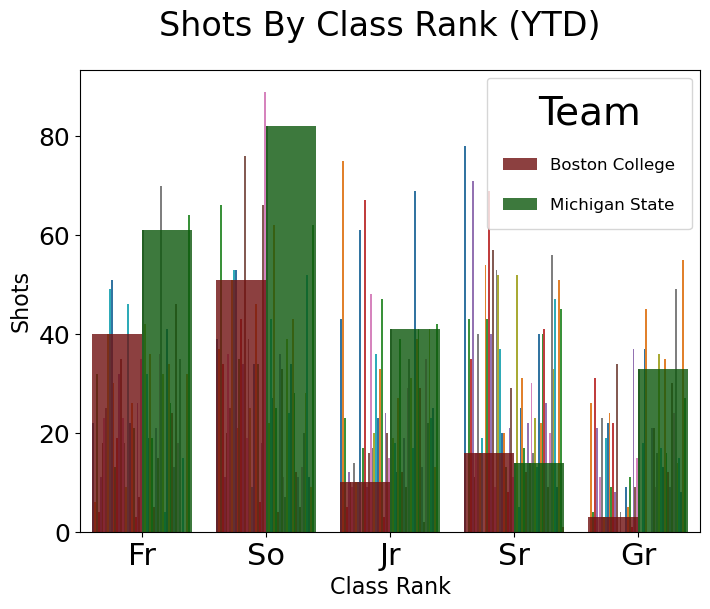

In [61]:
# Function to create individual plots for each metric
def create_metric_plot(metric, title):
    fig, ax = plt.subplots(figsize=figure_default)
    fig.suptitle(f'{title} By Class Rank (YTD)', fontsize=24)

    # Plot data for all teams using the 'tab10' palette
    sns.barplot(x='Yr.', y=metric, hue='Team', data=class_rank_stats_df, 
                palette='tab10', ax=ax, ci=None, order=class_rank_order)

    # Overlay larger, more opaque bars for Michigan State and Boston College
    sns.barplot(x='Yr.', y=metric, hue='Team', data=msu_bc_data, 
                palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax, ci=None, alpha=0.8, order=class_rank_order)

    # Add labels and title
    ax.set_xlabel('Class Rank', fontsize=14)
    ax.set_ylabel(title, fontsize=14)

    # Simplify the legend to only show Michigan State and Boston College
    handles, labels = ax.get_legend_handles_labels()
    # Only keep the last two handles for Michigan State and Boston College
    ax.legend(handles[-2:], labels[-2:], title='Team', fontsize='large', title_fontsize='28',
              # adjust the other font sizes
              labelspacing=1.5,  # increase spacing between items in the legend)
                borderpad=1,  # increase the spacing between the legend and the border
                # framealpha=1,  # increase transparency of the legend
                # bbox_to_anchor=(1.05, 1),  # move the legend to the right of the plot                
    )

    

    

    # Adjust font sizes for all portions of the plot
    # ax.title.set_fontsize(32)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=18)

    # # Save the plot within the TEMP FOLDER to TEMP/IMAGES/PLOT with auto generated names
    # TEMP_FOLDER = '../TEMP/'
    # plt.savefig(f'{TEMP_FOLDER}/images/OVERALL_{title}.png', bbox_inches='tight')
    

    # Show the plot
    plt.show()

# Create plots for Goals, Assists, PIM, and Shots
create_metric_plot('Total_Goals', 'Goals')

create_metric_plot('Total_Assists', 'Assists')
create_metric_plot('Total_PIM', 'Penalty Minutes')
create_metric_plot('Total_Shots', 'Shots')


## Plot the same Data But Use the AVG per Game

NameError: name 'class_rank_stats_avg_df' is not defined

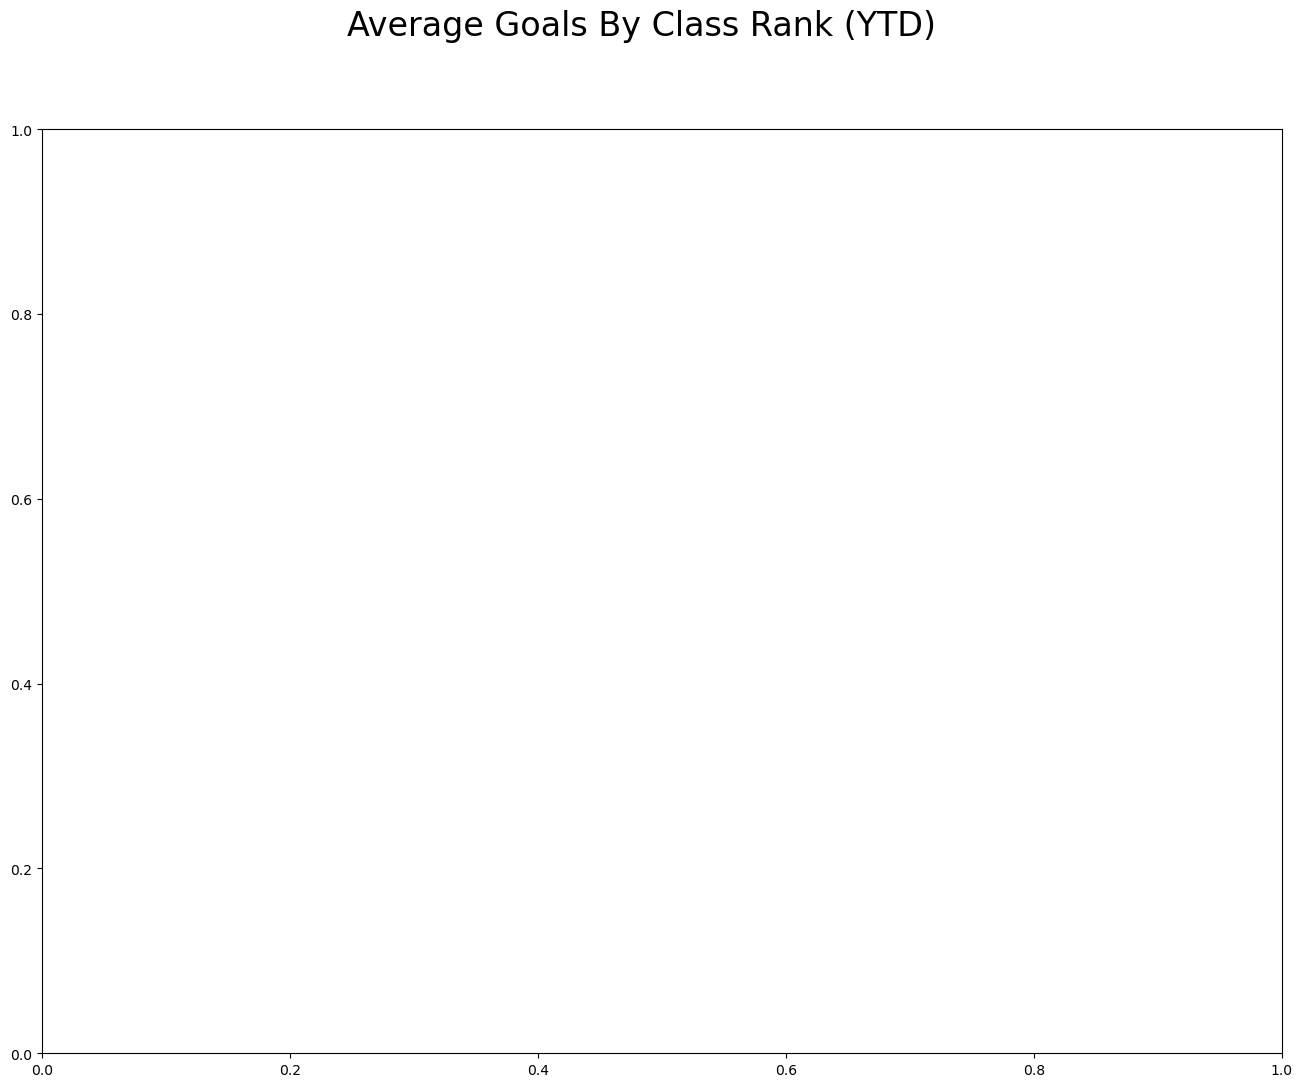

In [62]:
# Updated function to use the DataFrame with average metrics
def create_metric_plot_for_avg(metric, title):
    fig, ax = plt.subplots(figsize=figure_size2)
    fig.suptitle(f'{title} By Class Rank (YTD)', fontsize=24)

    # Plot data for all teams using the 'tab10' palette
    sns.barplot(x='Yr.', y=metric, hue='Team', data=class_rank_stats_avg_df, 
                palette='tab10', ax=ax, ci=None, order=class_rank_order)

    # Overlay larger, more opaque bars for Michigan State and Boston College
    sns.barplot(x='Yr.', y=metric, hue='Team', data=msu_bc_avg_data, 
                palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax, ci=None, alpha=0.8, order=class_rank_order)

    # Add labels and title
    ax.set_xlabel('Class Rank', fontsize=14)
    ax.set_ylabel(title, fontsize=14)

    # Simplify the legend to only show Michigan State and Boston College
    handles, labels = ax.get_legend_handles_labels()
    # Only keep the last two handles for Michigan State and Boston College
    ax.legend(handles[-2:], labels[-2:], title='Team', fontsize='large', title_fontsize='28',
              # adjust the other font sizes
              labelspacing=1.5,  # increase spacing between items in the legend)
                borderpad=1,  # increase the spacing between the legend and the border
                # framealpha=1,  # increase transparency of the legend
                # bbox_to_anchor=(1.05, 1),  # move the legend to the right of the plot
    )

    # Adjust font sizes for all portions of the plot
    # ax.title.set_fontsize(32)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=18)

    # Save the plot within the TEMP FOLDER to TEMP/IMAGES/PLOT with auto generated names
    # TEMP_FOLDER = '../TEMP/'
    # plt.savefig(f'{TEMP_FOLDER}/images/AVERAGE_{title}.png', bbox_inches='tight')
    


    # Show the plot
    plt.show()

# Let's try creating one of the plots to see if the updated function works as expected
create_metric_plot_for_avg('Avg_Goals', 'Average Goals')
# It works! Now let's create the other plots

# Create plots for Assists, PIM, and Shots
create_metric_plot_for_avg('Avg_Assists', 'Average Assists')
create_metric_plot_for_avg('Avg_PIM', 'Average Penalty Minutes')
create_metric_plot_for_avg('Avg_Shots', 'Average Shots')


## Scoring by Class Rank

### CLASS RANK IS NOT IN CURRENT VERSION OF DATABASE - GOING TO DO WORK IN ANOTHER NOTEBOOK TO BRING THAT DATA FROM THE MASTER_ROSTER tables into the database